In [1]:
import numpy as np
import pandas as pd

# Helper classes for data processing, state representation
from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
from reinforcetrader.state import EpisodeStateLoader
from reinforcetrader.dqn_agent import DRLAgent

# Import other uttilities
from reinforcetrader.utils.backtest_engine import BackTester

# Helper method for displaying large dataframes
from IPython.display import HTML
pd.set_option("display.max_rows", None)
from IPython.display import HTML, display

def display_df(df, rows=10):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

# Data Pre-processing and Feature Building
The `RawDataLoader` class downloads OHLCV data for all tickers in a specified index (if the `index` argument is provided). Otherwise, it expects a list of tickers for which the data will be downloaded.

It implements a caching feature for index data: if data for the requested date range already exists locally, it is loaded to minimize API calls. If not, the data is downloaded from Yahoo Finance and saved for future retrieval.

When an index is provided, the `get_hist_prices()` method returns both the ticker data and the benchmark index OHLCV data.

In [2]:
# Get DJI raw data using Yahoo Finance API
data_loader = RawDataLoader(start_date='1999-08-01', end_date='2025-09-08', index='DJI', verbose=False)

# Download or load the data from cache
ticker_data, benchmark_data = data_loader.get_hist_prices()

# Inspect the raw DJI tickers OHLCV data
display_df(ticker_data)

Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,HON,IBM,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT
Price,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,Close,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,High,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Open,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume,Volume
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-08-02,0.418406,27.008625,2.350000,26.759928,29.387833,15.095912,20.104944,17.283489,20.469769,43.679085,24.310873,34.258556,60.700554,23.358128,24.574469,14.529987,22.785528,18.153017,25.131224,25.952599,4.675045,0.038801,22.806925,6.088424,16.742905,6.037878,17.081629,9.014959,0.435292,27.437333,2.553125,27.930113,29.828851,15.192577,20.816444,17.532087,20.987395,44.896015,25.017303,34.557903,62.562537,23.612193,24.652980,14.802141,22.818840,18.356555,25.620794,26.602848,4.884898,0.038920,23.091616,6.158246,17.002989,6.178152,17.213026,9.254295,0.416529,26.279821,2.348438,26.708492,28.866630,15.047579,19.921987,17.224299,20.469769,43.374852,24.164715,34.158774,60.483324,23.246974,24.123020,14.514868,22.085972,17.733221,25.037973,25.818724,4.640070,0.038204,22.727844,6.032567,16.287758,5.952494,16.818835,8.935181,0.417467,26.279821,2.459375,27.158561,29.107185,15.112023,20.064287,17.295327,20.752110,44.678706,24.603188,34.358341,61.569479,23.358128,24.162277,14.650945,22.119285,17.898595,25.084597,26.220348,4.838264,0.038442,22.727844,6.032567,16.385289,5.952494,16.884533,9.001663,362443200,14186400,339356000,8751857,2641100,2118000,28405600,1705000,3526812,566400,4064100,1146355,4775095,3559800,6278850,5161000,2372700,2258287,3458295,48050600,14422400,313344000,4158800,581400,377100,3470400,3194070,16741800
1999-08-03,0.414653,26.279812,2.371875,26.065533,30.189676,14.918694,19.881329,17.614960,20.187426,42.288334,23.628819,33.826187,59.273014,23.929771,24.751118,14.711424,22.585655,18.343840,24.991341,25.933470,4.593437,0.037845,23.708429,6.046528,16.710386,5.592662,16.818830,8.921885,0.431070,27.158664,2.425000,27.055690,30.189676,15.192579,20.348885,17.626798,20.657996,43.679112,24.457044,34.491402,61.134996,24.136199,24.790373,14.787022,22.818840,18.394724,25.410970,26.335094,4.814948,0.038801,23.850775,6.102385,16.905449,5.854913,17.180172,9.121331,0.402457,25.786797,2.240625,25.924083,29.508103,14.805917,19.596729,17.259819,19.905084,42.244872,23.580098,33.593362,58.683387,23.643948,24.495951,14.545108,22.285846,18.178464,24.851465,25.818720,4.587608,0.037487,22.854356,5.990671,16.547834,5.574365,16.769557,8.788920,0.425910,27.072922,2.425000,26.901379,29.508103,15.095913,20.328557,17.567608,20.469768,43.679112,24.262168,34.258577,60.948796,23.850376,24.574464,14.545108,22.652280,18.292955,25.294406,26.277719,4.768314,0.038801,22.870173,6.060493,16.677876,5.854913,17.048775,9.054848,368379200,11616400,582780000,8694619,2854000,2275600,32937000,2072200,7458388,837700,585

The `FeatureBuilder` class computes features required for the Deep Q-Network (DQN) as well as features used in reward functions (e.g., look-ahead excess returns). The `get_feature_indices()` method returns index lists for OHLCV, reward-related, and DQN input features to prevent cross-contamination and look-ahead bias.  

Currently, the `FeatureBuilder` performs the following:  
- Builds features for each ticker, including inputs for the CNN branch and the technical indicators branch used in the DQN.  
- Saves computed features to a CSV file for optional separate analysis.  
- Returns separate index lists for reward function features, backtesting features (OHLCV), and RL state representation features to avoid look-ahead bias.  
- Implements the following features:  
  - **OHLCV**: Open, High, Low, Close, Volume  
  - **Reward Function**: Excess returns relative to the benchmark on user-specified horizons  
  - **State Representation**:  
    - Body/HL: Ratio of candlestick body length to daily high–low range  
    - UWick/HL: Ratio of upper wick to daily high–low range  
    - LWick/HL: Ratio of lower wick to daily high–low range  
    - Gap: Standardized log gap ($\ln \frac{open}{previous \space close}$)
    - Gap Fill: Percentage of gap filled after a gap up or gap down  
    - EMA Ratios: Standardized ratios EMA5/13, EMA13/26, EMA26/50  
    - Bollinger Bands: B%B (position of close relative to bands; upper=1, mid=0.5, lower=0) and standardized BBW  
    - RSI: Standardized Relative Strength Index  
    - ADX: Scaled Average Directional Index in [0, 1]  
    - Vol/Vol20: Standardized ratio of volume to 20-day average volume

In [3]:
# Instantiate Feature Builder to Build relevant features for state space
feature_builder = FeatureBuilder(ticker_data=ticker_data, benchmark_data=benchmark_data, f_prefix='DJI')

# Build the features
feature_builder.build_features()

# Store the computed features and the feature index ranges (used later)
features_data = feature_builder.get_features()
feature_indices = feature_builder.get_feature_indices()

# Inspect the features
display_df(features_data.head(), rows=20)

Building ticker features: 100%|█████████████████████████████████████| 28/28 [00:03<00:00,  7.95it/s]


File already exists, skipping save: data/processed/DJI_tickers_features_2000-04-07_2025-09-04.csv


# Episode Data Representation

In [4]:
WFV_config = {
    'mode': 'expanding', # supports 'expanding' or 'moving'
    'train_start': '2000-04-07',
    'train_end': '2019-09-30',
    'test_start': '2019-10-01',
    'test_end': '2025-07-31',
    'train_window_size': 1200,
    'val_window_size': 630
}

# Initialize the episode state loader
state_loader = EpisodeStateLoader(features_data, feature_indices, WFV_config)

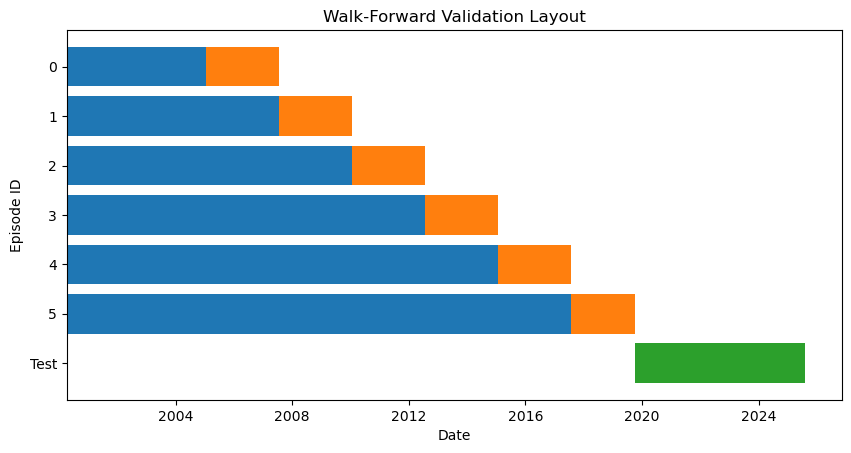

In [5]:
state_loader.get_WFV_plot()

In [6]:
state_loader.get_state_matrix('validate', 1, 'AAPL', 2, 4)

array([[ 0.5023908 ,  0.10286992,  0.39473928,  0.94036652,  0.99999199,
         1.37197209,  1.34762887,  1.52557013,  0.94597155,  1.5293353 ,
         1.3408398 ,  0.36767584,  0.64892816],
       [ 0.09091079,  0.35431275,  0.55477647, -0.6800312 ,  1.        ,
         1.35822791,  1.38924275,  1.55015461,  0.8925227 ,  1.67337636,
         1.30692157,  0.38244227,  0.21502136],
       [-0.5824806 ,  0.30948789,  0.10803151, -3.87205467,  0.43983149,
         0.49240165,  1.13292574,  1.45067191,  0.59270412,  1.52898289,
        -0.43630903,  0.37010576,  2.07364735],
       [-0.02678227,  0.30060121,  0.67261652,  1.56563672,  0.95528687,
         0.13291023,  0.97628149,  1.38264481,  0.65213482,  1.25991239,
        -0.18346913,  0.35865044,  1.23746504]])

In [7]:
state_loader.get_state_matrix('train', 1, 'AAPL', 2, 4)

array([[ 0.70588161,  0.01960538,  0.27451301,  0.75466916,  0.84852043,
        -1.10434345, -0.54260103, -0.24084798,  0.54550653, -0.05190091,
        -0.60825003,  0.17697014, -0.65409915],
       [ 0.70588161,  0.01960538,  0.27451301,  0.75466916,  0.84852043,
        -1.10434345, -0.54260103, -0.24084798,  0.54550653, -0.05190091,
        -0.60825003,  0.17697014, -0.65409915],
       [-0.83593518,  0.13281764,  0.03124718, -0.14768134,  1.        ,
        -1.37288814, -0.79271549, -0.4098988 ,  0.33455197, -0.12668056,
        -1.27256022,  0.16995583, -0.81033838],
       [-0.59634097,  0.20182069,  0.20183833, -0.75986002,  0.91666322,
        -1.82472261, -1.1539094 , -0.65317952,  0.13688477, -0.35446376,
        -1.73826413,  0.17283462,  0.93742527]])

In [8]:
state_loader.get_state_OHLCV('train', 1, 'AAPL', 1)

{'Open': 0.9883182851073096,
 'High': 0.9962927361186478,
 'Low': 0.9362521332074276,
 'Close': 0.9381282329559326,
 'Volume': 212262400.0}

In [9]:
state_loader.get_reward_computes('train', 1, 'AAPL', 1)

{'1DFRet': -0.04449984052536404}

# Deep Q-Network and RL Agent

In [10]:
# Init the RL agent and DQN Model
agent_config = {
    'num_features': len(feature_indices['State']),
    'learning_rate': 1e-3,
    'dropout_p': 0.1,
    'memory_buffer_len': 200000,
    'state_matrix_window': 60,
    'epsilon_start': 1.0,
    'epsilon_min': 0.05,
    'epsilon_boost_factor': 0.3,
    'decay_updates': 50000,
    'discount_factor': 0.95,
    'batch_size': 256,
    'replay_start_size': 5000,
    'train_interval': 1,
}

agent = DRLAgent(agent_config=agent_config, reward_type='DDDR')

I0000 00:00:1766015631.719717   69946 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3584 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


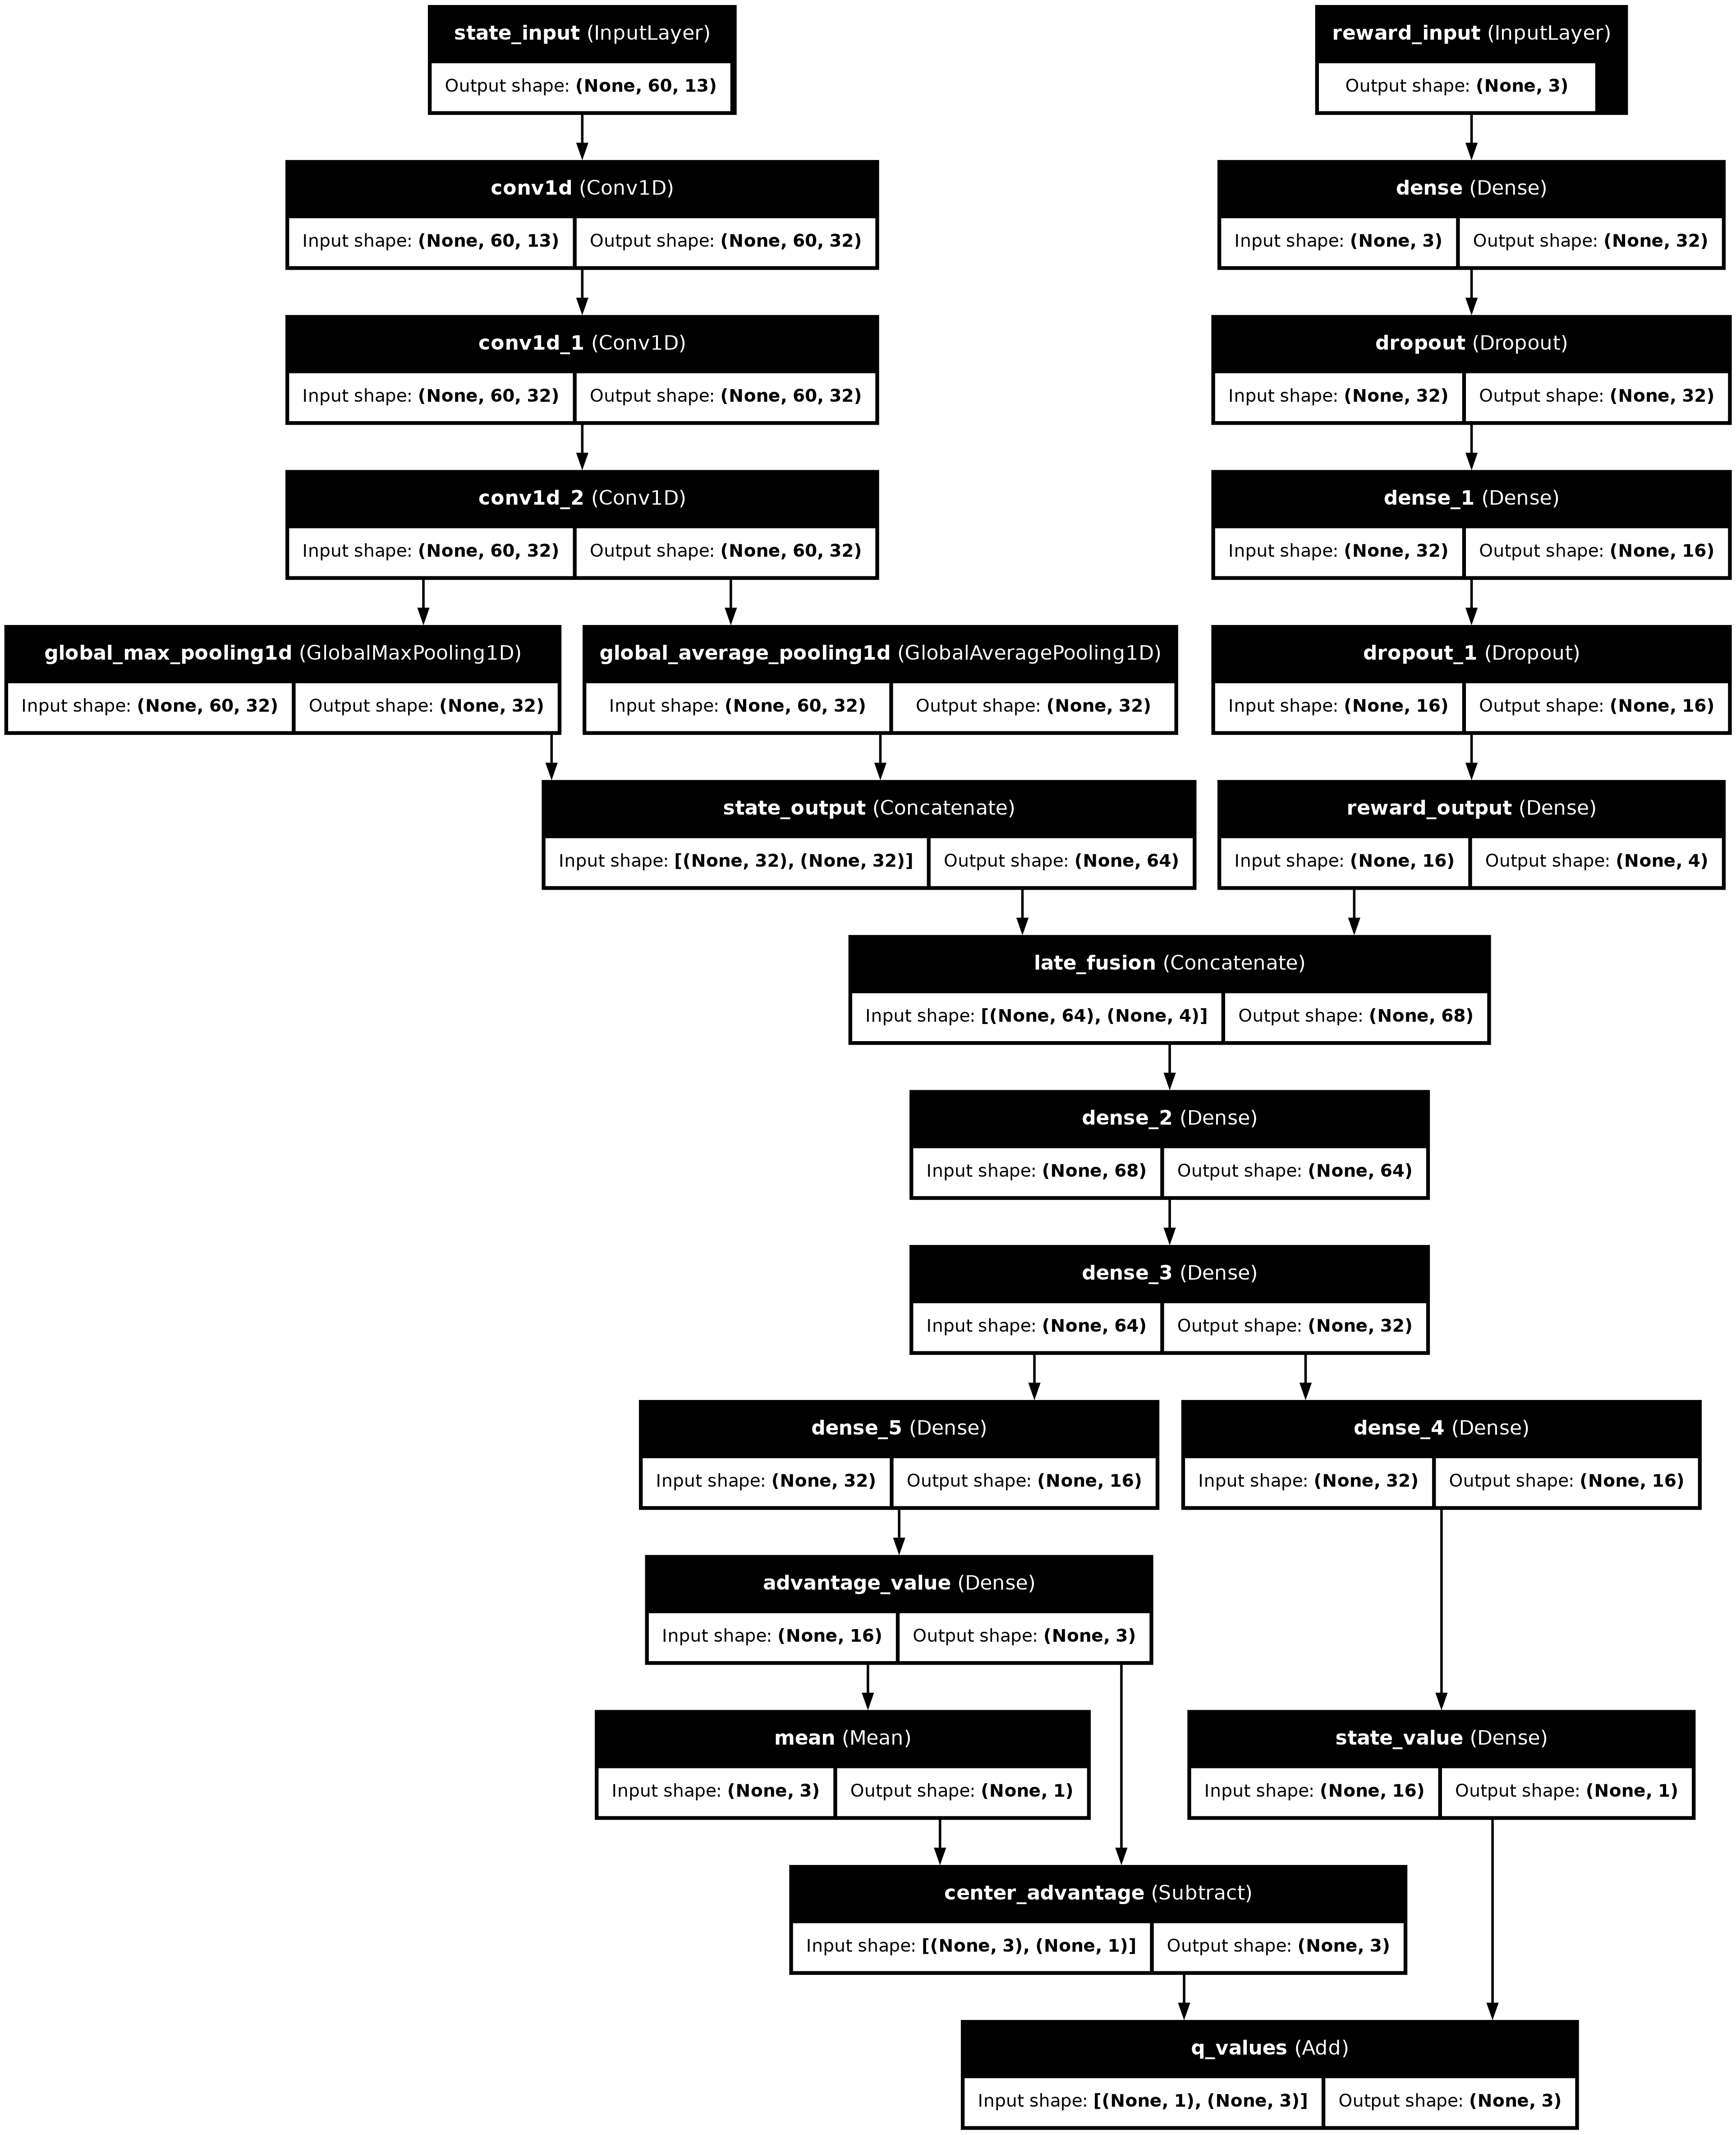

In [11]:
from tensorflow.keras.utils import plot_model
plot_model(agent.get_model(), to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Train Agent

In [12]:
training_config = {
    'model_dir': 'model_checkpoints/',
    'plots_dir': 'plots/',
    'logs_dir': 'logs/'
}

In [ ]:
agent.train(state_loader, [0, 1], training_config)

Training episode 0:  18%|███████▊                                    | 5/28 [02:03<16:45, 43.72s/it]

# Test Agent Performance

In [ ]:
test_config = {
    'plots_dir': 'plots/',
    'logs_dir': 'logs/',
    'outputs_dir': 'data/test/'
}
agent = DRLAgent(agent_config=agent_config, reward_type='DDDR', model_path='./model_checkpoints/model_20251121_024051.keras')
signals, prices = agent.test(state_loader, 0, test_config)

Loading model from ./model_checkpoints/model_20251121_024051.keras


Testing episode 0:   7%|███▏                                         | 2/28 [01:01<13:13, 30.54s/it]

In [14]:
signals.tail()

Ticker,AAPL,AMGN,AMZN,AXP,BA,CAT,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,NVDA,PG,SHW,TRV,UNH,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2025-07-25,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}",...,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}"
2025-07-28,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}",...,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}"
2025-07-29,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}",...,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}"
2025-07-30,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}",...,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}"
2025-07-31,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}",...,"{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}","{'buy': 0, 'hold': 1, 'sell': 0}"


In [ ]:
# import numpy as np
# import pandas as pd

# # Helper classes for data processing, state representation
# from reinforcetrader.data_pipeline import RawDataLoader, FeatureBuilder
# from reinforcetrader.state import EpisodeStateLoader
# from reinforcetrader.dqn_agent import RLAgent

# # Import other uttilities
# from reinforcetrader.utils.portfolio_manager import PortfolioBackTester

# # Helper method for displaying large dataframes
# from IPython.display import HTML
# pd.set_option("display.max_rows", None)
# from IPython.display import HTML, display

# def display_df(df, rows=10):
#     # Puts the scrollbar next to the DataFrame
#     display(HTML("<div style='height: 300px; overflow: auto; width: 98%'>" + df.head(rows).to_html() + "</div>"))

# signals_dir = 'data/test/signals_20250911_223500.pkl'
# prices_dir = 'data/test/prices_20250911_223500.pkl'

# signals, prices = pd.read_pickle(signals_dir), pd.read_pickle(prices_dir)

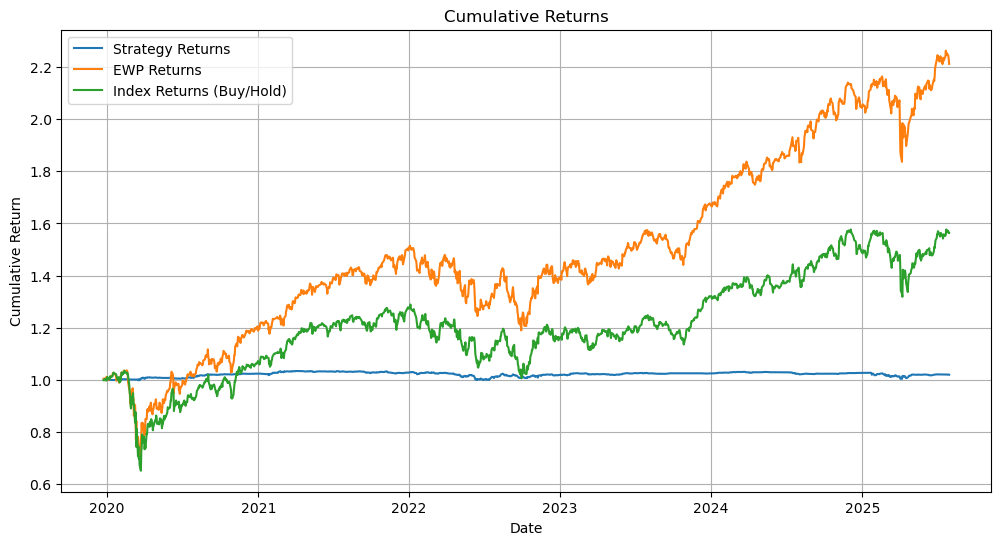

{'Total Strategy Returns': 0.019541496211568754,
 'Annualized Strategy Returns': -0.5060475042612824,
 'Max Strategy Drawdown': -0.03409582647660747,
 'EWP Total Return': 1.2119276523590088,
 'EWP Annualized Return': 0.03505086898803711,
 'EWP Max Drawdown': -0.32934248447418213,
 'Index Total Return': 0.5632433491447035,
 'Index Annualized Return': -0.09777097899011167,
 'Index Max Drawdown': -0.3708617136959429,
 'Sharpe Ratio (ann, rf=0)': 0.2159266146398662,
 'Sortino Ratio (ann, rf=0)': 0.25968165942847005,
 'Information Ratio (vs Index, ann)': -0.471635276766381}


In [12]:
pbt = PortfolioBackTester(signals, prices)
pbt.run_backtest()